In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.metrics import root_mean_squared_error
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
DATA_PATH = 'processed_data'
COMMODITIES = ['Maize', 'Wheat', 'Oats', 'Soybeans']
COMMODITIES_LOCS = {'Maize': 1, 'Oats': 2, 'Soybeans': 3, 'Wheat': 4}
TEST_SIZE = 0.1

## Time Series Forecasting

In [3]:
WINDOW_SIZE = 100
BASE_HIDDEN_SIZE = 40
NUM_LAYERS = 2
EXTRA_FC_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 50

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=WINDOW_SIZE):
        self.data = data
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        # return (X, y) pair
        return self.data[idx:idx+self.window_size], self.data[idx+self.window_size]

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, extra_fc_layers=0):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
        if extra_fc_layers > 0:
            self.extra_fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(extra_fc_layers)])
            self.activation = nn.ReLU()
        else:
            self.extra_fc_layers = None
            self.activation = None
    
    def forward(self, x):
        out, _ = self.rnn(x)
        if self.extra_fc_layers is not None:
            for layer in self.extra_fc_layers:
                out = layer(out)
                out = self.activation(out)
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, extra_fc_layers=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
        if extra_fc_layers > 0:
            self.extra_fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(extra_fc_layers)])
            self.activation = nn.ReLU()
        else:
            self.extra_fc_layers = None
            self.activation = None
    
    def forward(self, x):
        out, _ = self.lstm(x)
        if self.extra_fc_layers is not None:
            for layer in self.extra_fc_layers:
                out = layer(out)
                out = self.activation(out)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
def test_model(model, test_loader, criterion, loc=1, calc_rmse=True):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            rel_targets = targets[:, (loc-1)*4:loc*4]
            loss = criterion(outputs, rel_targets)
            total_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(rel_targets)
    
    all_outputs = torch.cat(all_outputs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    if calc_rmse:
        rmse = root_mean_squared_error(all_targets, all_outputs)
        return total_loss / len(test_loader), rmse
    else:
        return total_loss / len(test_loader)


In [8]:
def train_model(model, train_loader, test_loader, criterion, optimizer, loc=1, num_epochs=NUM_EPOCHS):
    train_losses = []
    test_losses = []
    calc_losses = test_loader is not None
    best_loss = np.inf
    best_model = None
    for _ in tqdm(range(num_epochs)):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            rel_targets = targets[:, (loc - 1)*4:loc * 4]
            loss = criterion(outputs, rel_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if calc_losses:
            train_loss = test_model(model, train_loader, criterion, loc=loc, calc_rmse=False)
            train_losses.append(train_loss)
            test_loss = test_model(model, test_loader, criterion, loc=loc, calc_rmse=False)
            test_losses.append(test_loss)
            if test_loss < best_loss:
                best_loss = test_loss
                best_model = model.state_dict()
    
    if calc_losses:
        return train_losses, test_losses, best_model
    return

In [9]:
def create_commodity_dataloaders(commodity, test_size=TEST_SIZE): 
    base_df = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    base_df.drop(columns=['Date'], inplace=True)
    test_segment = - int(test_size * len(base_df))

    train_data, val_data, test_data = base_df[:2 * test_segment], base_df[2 * test_segment: test_segment], base_df[test_segment:]

    train_dataset = TimeSeriesDataset(torch.tensor(train_data.values).float())
    val_dataset = TimeSeriesDataset(torch.tensor(val_data.values).float())
    test_dataset = TimeSeriesDataset(torch.tensor(test_data.values).float())

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [10]:
def eval_sequential_model(commodities_lst=COMMODITIES, model_name='RNN', hidden_size=BASE_HIDDEN_SIZE, num_layers=1, 
                          extra_fc_layers=0, lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True):
    for commodity in commodities_lst:
        train_loader_commodity, val_loader_commodity, test_loader_commodity = create_commodity_dataloaders(commodity)
        if model_name == 'RNN':
            model = RNNModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        elif model_name == 'LSTM':
            model = LSTMModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        else:
            print('Invalid model')
            return
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if calc_losses:
            train_losses, val_losses, best_model = \
                train_model(model, train_loader_commodity, val_loader_commodity,
                            criterion, optimizer, num_epochs=num_epochs)
            model.load_state_dict(best_model)
                
        else:
            train_model(model, train_loader_commodity, None,
                        criterion, optimizer, num_epochs=num_epochs)
        
        if calc_losses:
            plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
            plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss vs Validation Loss for {}'.format(commodity))
            plt.legend()
            plt.show()
        
        print(f'{commodity} Best Model Validation Loss: {val_losses[-1]:.4f}')
        _, rmse = test_model(model, test_loader_commodity, criterion, calc_rmse=True)
        print(f'{commodity} Final Model Test RMSE: {rmse:.4f}')
        print()

100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


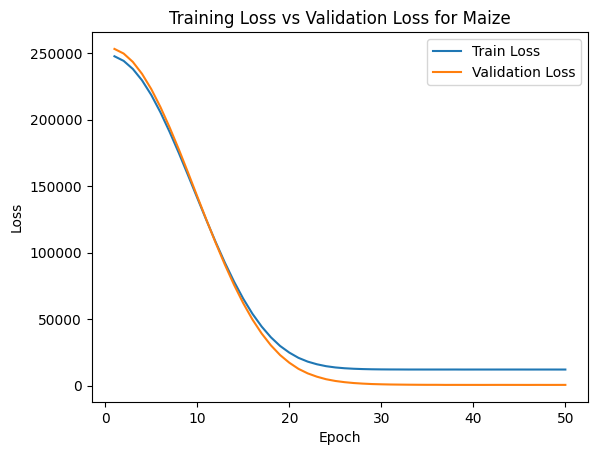

Maize Best Model Validation Loss: 520.7323
Maize Final Model Test RMSE: 31.5300



100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


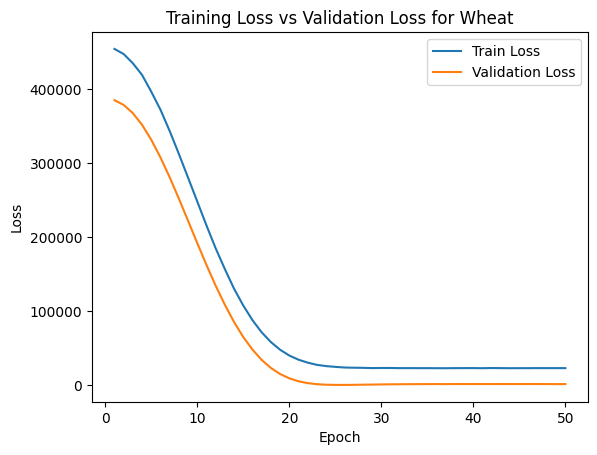

Wheat Best Model Validation Loss: 1870.5859
Wheat Final Model Test RMSE: 59.7913



100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


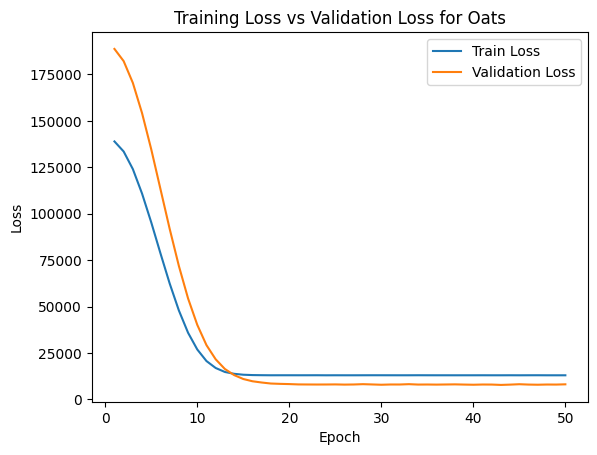

Oats Best Model Validation Loss: 8151.1382
Oats Final Model Test RMSE: 31.7900



100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


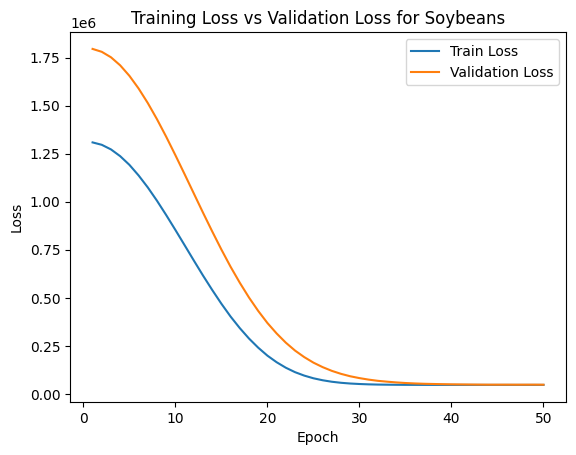

Soybeans Best Model Validation Loss: 47689.8418
Soybeans Final Model Test RMSE: 58.8439



In [11]:
eval_sequential_model(model_name='RNN', num_layers=NUM_LAYERS, hidden_size=BASE_HIDDEN_SIZE, extra_fc_layers=EXTRA_FC_LAYERS, 
                      lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True)

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


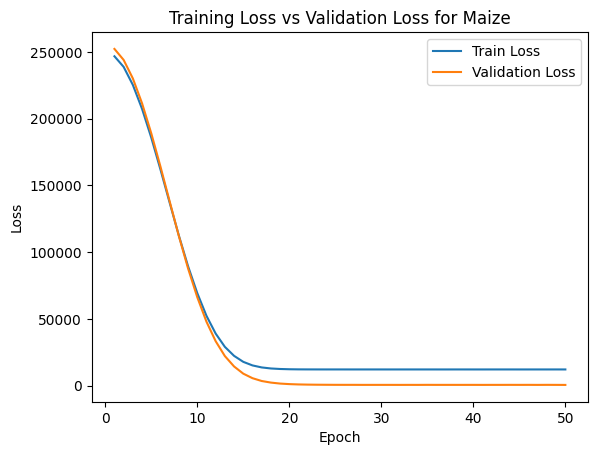

Maize Best Model Validation Loss: 477.2635
Maize Final Model Test RMSE: 32.1477



100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


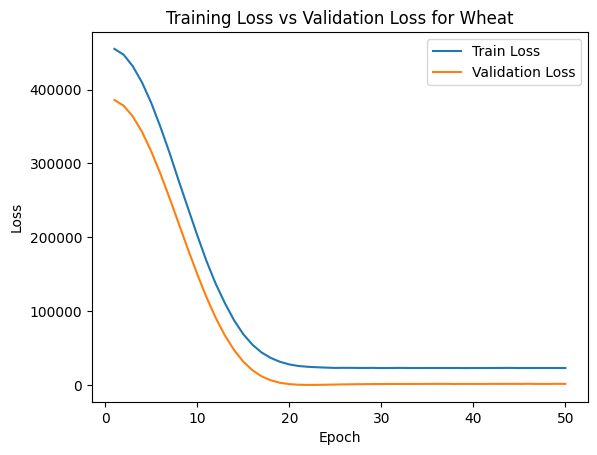

Wheat Best Model Validation Loss: 1920.3699
Wheat Final Model Test RMSE: 59.6973



100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


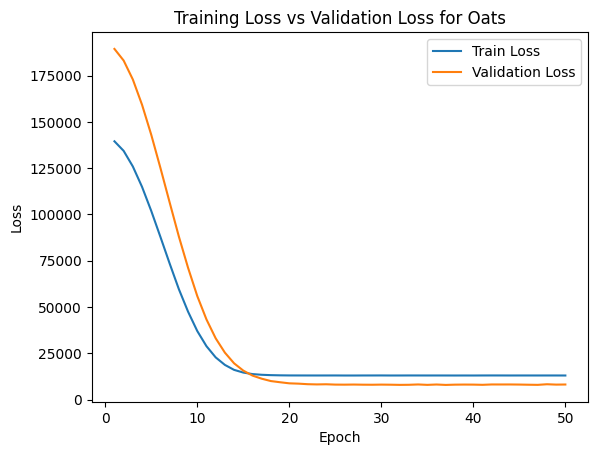

Oats Best Model Validation Loss: 8152.8811
Oats Final Model Test RMSE: 31.8137



100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


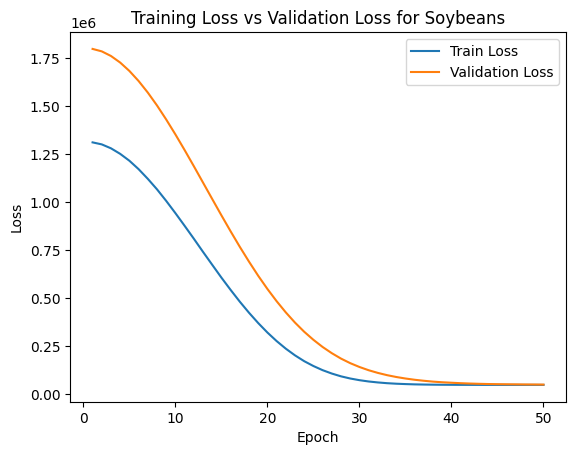

Soybeans Best Model Validation Loss: 48294.5293
Soybeans Final Model Test RMSE: 59.5514



In [12]:
eval_sequential_model(model_name='LSTM', num_layers=NUM_LAYERS, hidden_size=BASE_HIDDEN_SIZE, extra_fc_layers=EXTRA_FC_LAYERS, 
                      lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True)

In [13]:
def eval_sequential_model_for_all(model_name='RNN', hidden_size=BASE_HIDDEN_SIZE, num_layers=1, 
                                  extra_fc_layers=0, lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True):
    train_loader_commodity, val_loader_commodity, test_loader_commodity = create_commodity_dataloaders('dataset')
    for commodity in COMMODITIES:
        loc = COMMODITIES_LOCS[commodity]
        if model_name == 'RNN':
            model = RNNModel(input_size=18, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        elif model_name == 'LSTM':
            model = LSTMModel(input_size=18, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        else:
            print('Invalid model')
            return
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if calc_losses:
            train_losses, val_losses, best_model = \
                train_model(model, train_loader_commodity, val_loader_commodity,
                            criterion, optimizer, loc=loc, num_epochs=num_epochs)
            model.load_state_dict(best_model)
                
        else:
            train_model(model, train_loader_commodity, None,
                        criterion, optimizer, num_epochs=num_epochs)
        
        if calc_losses:
            plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
            plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss vs Validation Loss for {} Predictions'.format(commodity))
            plt.legend()
            plt.show()
        
        print(f'{commodity} Prediction Mission, Best Model Validation Loss: {val_losses[-1]:.4f}')
        _, rmse = test_model(model, test_loader_commodity, criterion, loc=loc, calc_rmse=True)
        print(f'{commodity} Prediction Mission, Final Model Test RMSE: {rmse:.4f}')
        print()

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


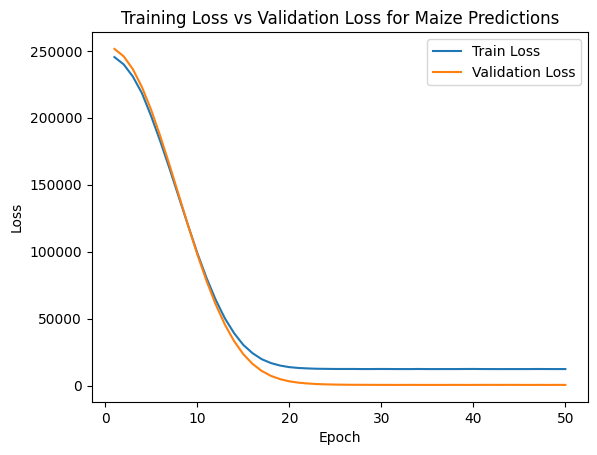

Maize Prediction Mission, Best Model Validation Loss: 545.9362
Maize Prediction Mission, Final Model Test RMSE: 31.9014



100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


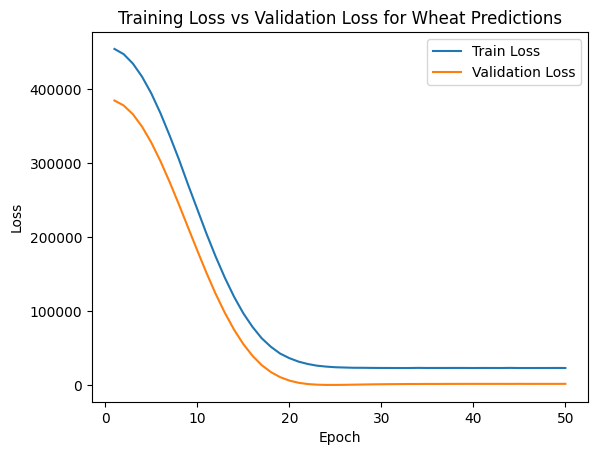

Wheat Prediction Mission, Best Model Validation Loss: 1947.2452
Wheat Prediction Mission, Final Model Test RMSE: 59.7156



100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


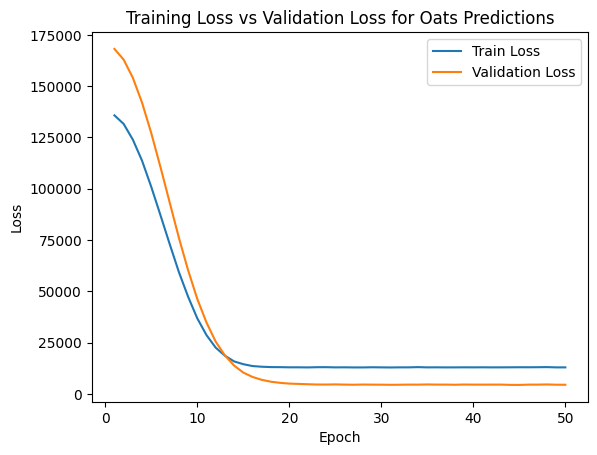

Oats Prediction Mission, Best Model Validation Loss: 4455.2991
Oats Prediction Mission, Final Model Test RMSE: 32.0661



100%|██████████| 50/50 [01:22<00:00,  1.66s/it]


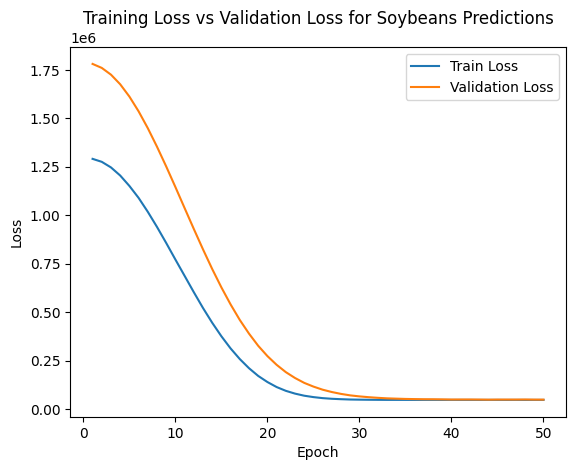

Soybeans Prediction Mission, Best Model Validation Loss: 48150.7734
Soybeans Prediction Mission, Final Model Test RMSE: 58.8685



In [14]:
eval_sequential_model_for_all(model_name='RNN', num_layers=NUM_LAYERS, hidden_size=BASE_HIDDEN_SIZE, extra_fc_layers=EXTRA_FC_LAYERS, 
                              lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True)

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


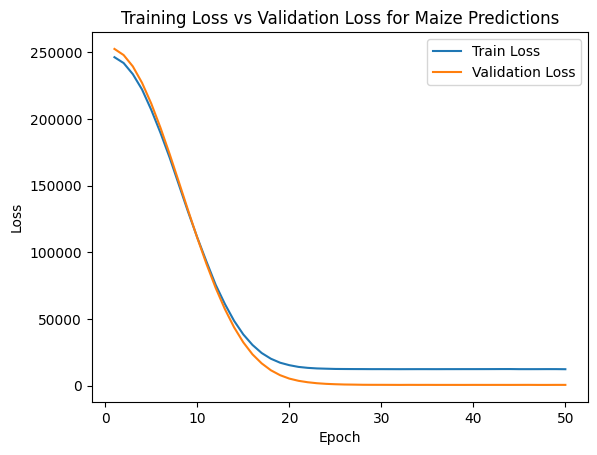

Maize Prediction Mission, Best Model Validation Loss: 559.3806
Maize Prediction Mission, Final Model Test RMSE: 31.7126



100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


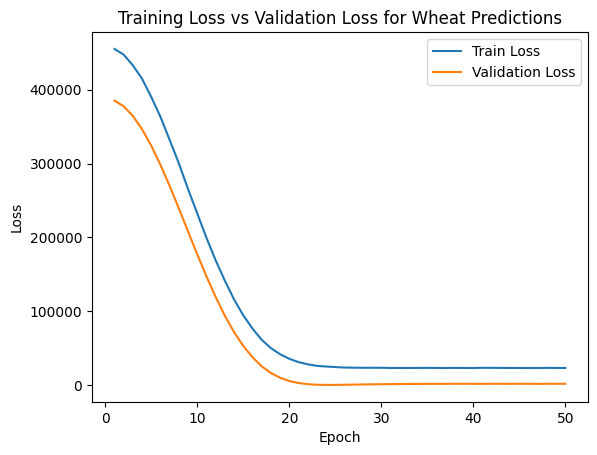

Wheat Prediction Mission, Best Model Validation Loss: 1961.5646
Wheat Prediction Mission, Final Model Test RMSE: 59.6936



100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


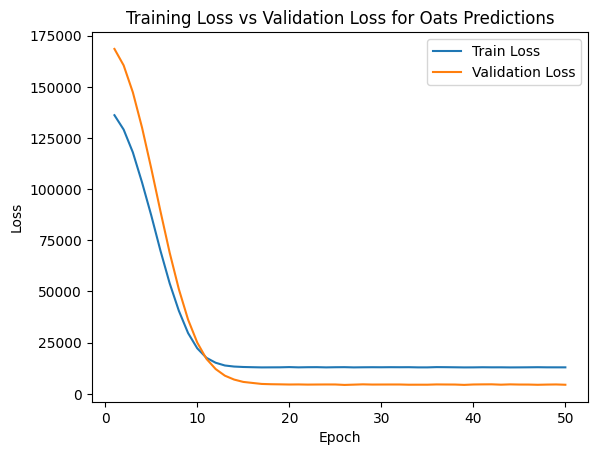

Oats Prediction Mission, Best Model Validation Loss: 4412.4495
Oats Prediction Mission, Final Model Test RMSE: 32.0358



100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


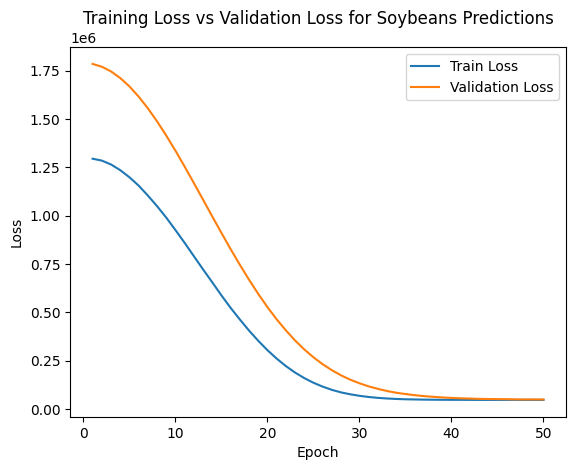

Soybeans Prediction Mission, Best Model Validation Loss: 49080.2188
Soybeans Prediction Mission, Final Model Test RMSE: 59.9254



In [15]:
eval_sequential_model_for_all(model_name='LSTM', num_layers=NUM_LAYERS, hidden_size=BASE_HIDDEN_SIZE, extra_fc_layers=EXTRA_FC_LAYERS, 
                              lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True)